In [43]:
import os 
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

In [45]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [46]:
import torch_geometric.nn as gnn
from torch_cluster import knn_graph
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import add_self_loops
from torch_geometric.transforms import SamplePoints, NormalizeFeatures

In [47]:
warnings.filterwarnings("ignore")
device = "cpu" if torch.cuda.is_available() else "cpu"

In [48]:
data = pd.read_csv('new_physics_signal.csv')
data = data.dropna()
shuffled = data.sample(frac=1, random_state=4)
data_zero = shuffled.loc[shuffled['Class'] == 0].sample(n=600, random_state = 123)
data_one = shuffled.loc[shuffled['Class'] == 1]

data_sampled_concated = pd.concat([data_zero, data_one]).sample(frac=1, random_state=4)
data_sampled_concated = data_sampled_concated.reset_index(drop=True)
data = data_sampled_concated
columns = data.columns

In [49]:
data.shape

(1092, 15)

In [50]:
X_arr = np.array(data.iloc[:, :-1])
y_arr = np.array(data.iloc[:, -1:])

X = torch.tensor(X_arr, dtype=torch.float32)
y = torch.tensor(y_arr, dtype=torch.long).reshape(X.shape[0],)

In [51]:
train_mask = torch.zeros(data.shape[0], dtype=torch.bool)
test_mask = torch.zeros(data.shape[0], dtype=torch.bool)

In [52]:
train_idx_stop = X.shape[0] - int(0.1 * X.shape[0]) - 1

In [53]:
train_mask[pd.RangeIndex(start=0, stop=train_idx_stop, step=1)] = True
test_mask[pd.RangeIndex(start=train_idx_stop + 1, stop=X.shape[0], step=1)] = True

In [54]:
edge_index = knn_graph(X, k=5)
edge_index = add_self_loops(edge_index)[0]

In [55]:
GraphData = Data(x=X, edge_index = edge_index, y=y, train_mask = train_mask, test_mask = test_mask)
GraphDataNorm = NormalizeFeatures()(GraphData)

In [56]:
class GCN_Model(torch.nn.Module):
    def __init__(self, in_features, out_features, num_classes):
        super(GCN_Model, self).__init__()
        self.conv1 = gnn.GATConv(in_features, out_features, heads=2, concat=True)
        self.conv2 = gnn.GATConv(2 * out_features, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [57]:
class GAT_Model(torch.nn.Module):
    def __init__(self, in_features, out_features, num_classes):
        super(GAT_Model, self).__init__()
        self.conv1 = gnn.GCN(in_features, out_features, heads=2, concat=True)
        self.conv2 = gnn.GCN(out_features, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [58]:
model = GCN_Model(14, 32, 2).to(device)
GraphData = GraphData.to(device)

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01753)

In [60]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")

In [61]:
def train(model):
    model.train()
    optimizer.zero_grad()
    y = GraphData.y[GraphData.train_mask]
    output = model(GraphData.x, GraphData.edge_index)[GraphData.train_mask]
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    return loss.item(), model

In [62]:
def test(model, viz = False):
    with torch.no_grad():
        model.eval()
        x = GraphData.x
        y = GraphData.y
        edge_index = GraphData.edge_index
        train_mask = GraphData.train_mask
        test_mask = GraphData.test_mask
        
        logits = model(x, edge_index)
        train_predictions = logits[train_mask].max(1)[1]
        test_predictions = logits[test_mask].max(1)[1]
        train_acc = train_predictions.eq(y[train_mask]).sum().item() / train_mask.sum().item()
        test_acc = test_predictions.eq(y[test_mask]).sum().item() / test_mask.sum().item()
        if viz:
            visualize(logits, color=y.to('cpu'))
        return train_acc, test_acc

<IPython.core.display.Javascript object>

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1 | Loss: 59.2985 Train ACC: 0.5733 Test ACC: 0.5963
Epoch: 2 | Loss: 16.2292 Train ACC: 0.5458 Test ACC: 0.5780
Epoch: 3 | Loss: 16.1397 Train ACC: 0.5458 Test ACC: 0.5780
Epoch: 4 | Loss: 20.4808 Train ACC: 0.5458 Test ACC: 0.5780
Epoch: 5 | Loss: 16.3555 Train ACC: 0.5458 Test ACC: 0.5780
Epoch: 6 | Loss: 12.8861 Train ACC: 0.5499 Test ACC: 0.5780
Epoch: 7 | Loss: 7.4033 Train ACC: 0.5499 Test ACC: 0.5780
Epoch: 8 | Loss: 11.8453 Train ACC: 0.5550 Test ACC: 0.5872
Epoch: 9 | Loss: 11.8875 Train ACC: 0.5550 Test ACC: 0.5872


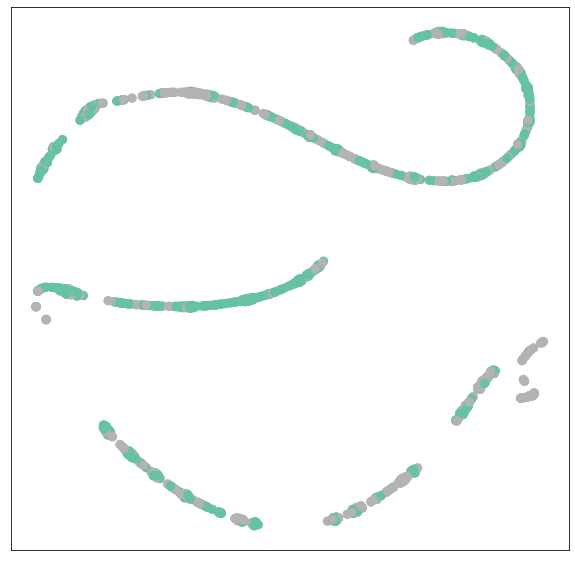

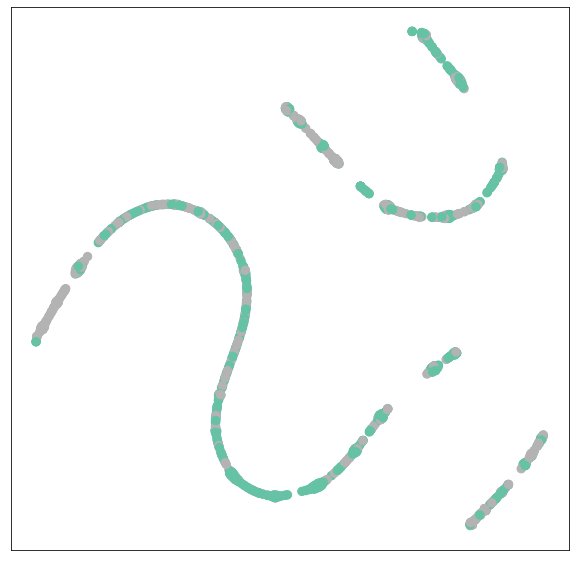

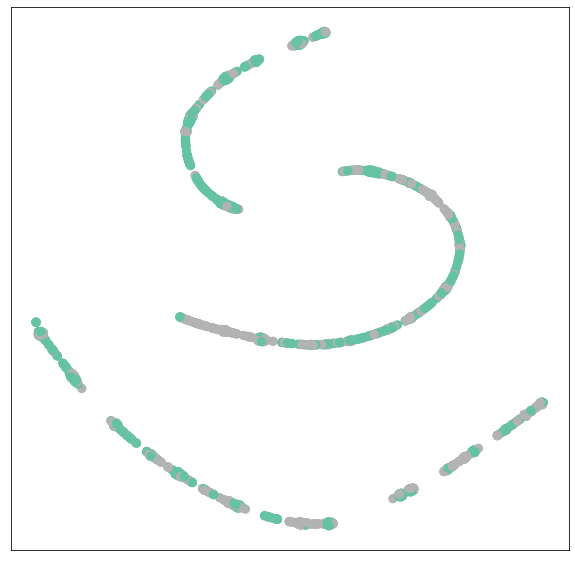

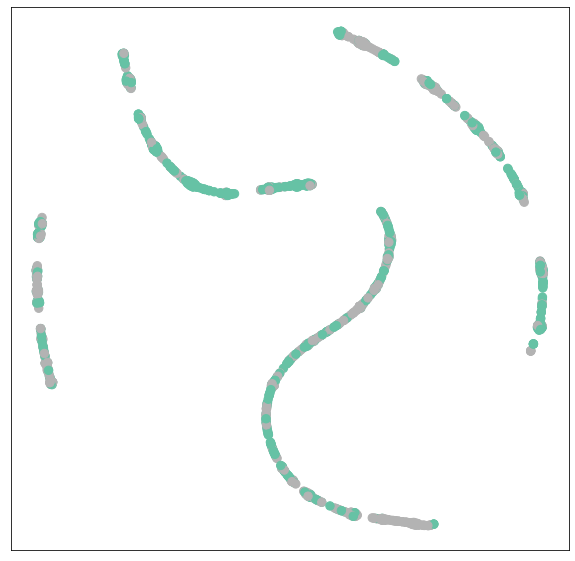

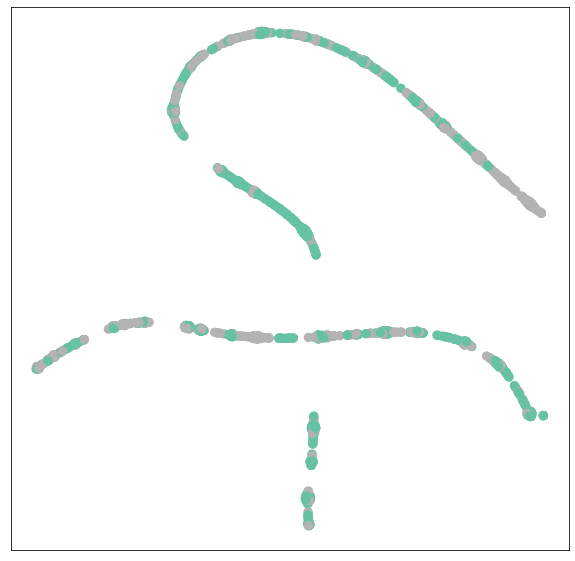

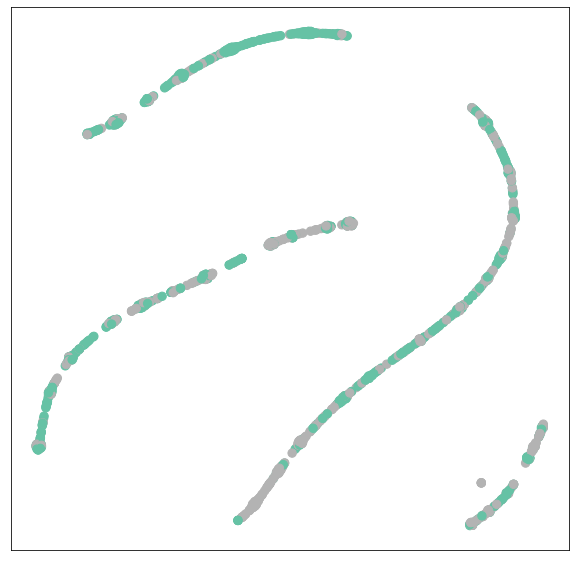

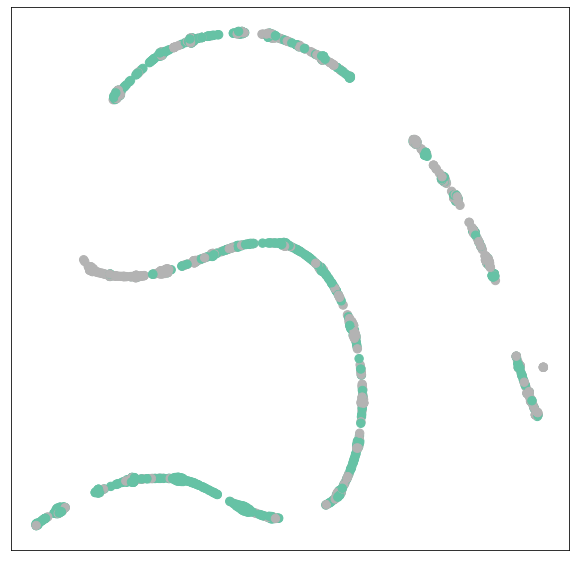

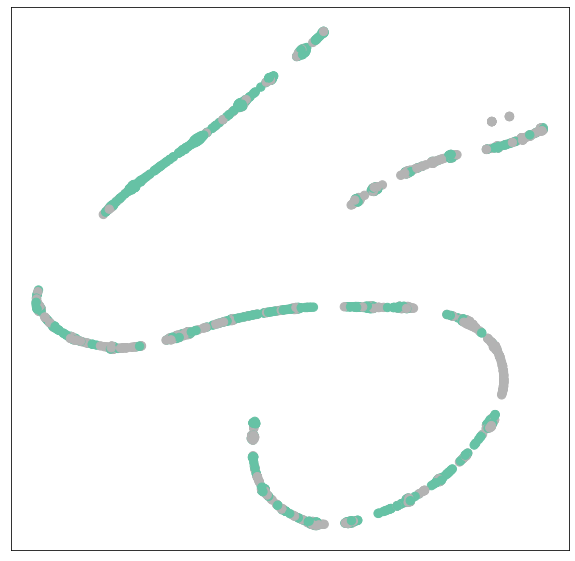

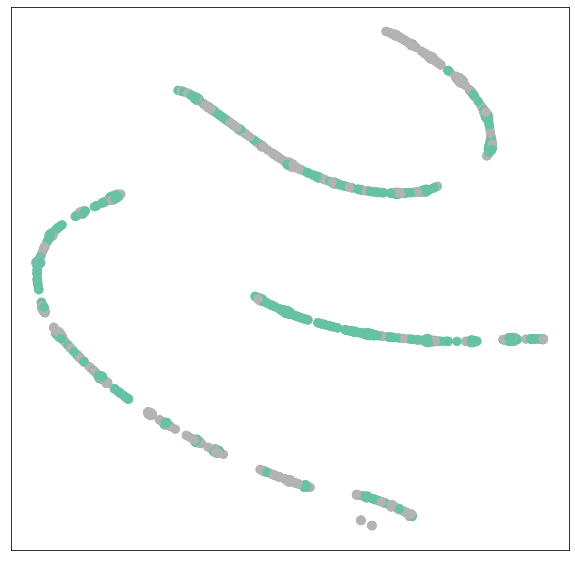

In [63]:
from IPython.display import Javascript  
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

epochs = 10
for epoch in tqdm(range(1, epochs), total = epochs-1):
    loss, model = train(model)
    train_acc, test_acc = test(model, viz = True) 
    print(f"Epoch: {epoch} | Loss: {loss:.4f} Train ACC: {train_acc:.4f} Test ACC: {test_acc:.4f}")